# Prediction Using Different Machine Learning Methods
## 4 Random Forests

In this notebook, we'll train a Random Forest Regression model for predicting building energy consumption based on historical enregy data and several weather variables. We'll use daily energy data and weather data to predict energy consumption.

In [1]:
%matplotlib inline 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.options.display.mpl_style = 'default'

In [2]:
import seaborn as sns
import scipy as sp
import sklearn
import sklearn.cross_validation
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score


In this notebook, we'll train a Random Forest Regression model for predicting building energy consumption based on historical enregy data and several weather variables. We'll use daily energy data and weather data to predict energy consumption.

In [3]:
# read in original data:
electricity = pd.read_excel('Data/dailyElectricityWithFeatures.xlsx')
electricity = electricity.drop('startDay', 1).drop('endDay', 1)
#electricity = electricity.drop('humidityRatio-kg/kg',1).drop('coolingDegrees',1).drop('heatingDegrees',1).drop('dehumidification',1).drop('occupancy',1)
electricity = electricity.dropna()

chilledWater = pd.read_excel('Data/dailyChilledWaterWithFeatures.xlsx')
chilledWater = chilledWater.drop('startDay', 1).drop('endDay', 1)
chilledWater = chilledWater.dropna()

steam = pd.read_excel('Data/dailySteamWithFeatures.xlsx')
steam = steam.drop('startDay', 1).drop('endDay', 1)
steam = steam.dropna()

In [4]:
# normalize data:
normalized_electricity = electricity - electricity.mean()
normalized_chilledWater = chilledWater - chilledWater.mean()
normalized_steam = steam - steam.mean()

Adding a new column to specify if working days or weekends and holidays. We'll set working days to 0, and weekends and holidays to 1. US public holidays are listed here, http://www.officeholidays.com/countries/usa/ We may also remove vacations times when there is no school, but we'll do it since we don't have this information.

In [5]:
# Initialization all days to 0
normalized_electricity['day_type'] = np.zeros(len(normalized_electricity))
normalized_chilledWater['day_type'] = np.zeros(len(normalized_chilledWater))
normalized_steam['day_type'] = np.zeros(len(normalized_steam))

# Set weekends to 1
normalized_electricity['day_type'][(normalized_electricity.index.dayofweek==5)|(normalized_electricity.index.dayofweek==6)] = 1
normalized_chilledWater['day_type'][(normalized_chilledWater.index.dayofweek==5)|(normalized_chilledWater.index.dayofweek==6)] = 1
normalized_steam['day_type'][(normalized_steam.index.dayofweek==5)|(normalized_steam.index.dayofweek==6)] = 1

# Set holidays to 1
holidays = ['2014-01-01','2014-01-20','2014-05-26','2014-07-04','2014-09-01','2014-11-11','2014-11-27','2014-12-25','2013-01-01',
            '2013-01-21','2013-05-27','2013-07-04','2013-09-02','2013-11-11','2013-11-27','2013-12-25','2012-01-01','2012-01-16',
            '2012-05-28','2012-07-04','2012-09-03','2012-11-12','2012-11-22','2012-12-25']

for i in range(len(holidays)):
    normalized_electricity['day_type'][normalized_electricity.index.date==np.datetime64(holidays[i])] = 1
    normalized_chilledWater['day_type'][normalized_chilledWater.index.date==np.datetime64(holidays[i])] = 1
    normalized_steam['day_type'][normalized_steam.index.date==np.datetime64(holidays[i])] = 1

Analysis of electricity data.

In [6]:
# Split train and test data:
elect_train = pd.DataFrame(data=normalized_electricity, index=np.arange('2012-01', '2014-01', dtype='datetime64[D]')).dropna()
elect_test = pd.DataFrame(data=normalized_electricity, index=np.arange('2014-01', '2014-11', dtype='datetime64[D]')).dropna()

XX_elect_train = elect_train.drop('electricity-kWh', axis = 1).reset_index().drop('index', axis = 1)
XX_elect_test = elect_test.drop('electricity-kWh', axis = 1).reset_index().drop('index', axis = 1)

YY_elect_train = elect_train['electricity-kWh']
YY_elect_test = elect_test['electricity-kWh']

print XX_elect_train.shape, XX_elect_test.shape

(634, 13) (294, 13)


In [7]:
XX_elect_train.head()

RH-%        T-C     Tdew-C  pressure-mbar  solarRadiation-W/m2  \
0   8.212490  -4.533170  -2.381563      -6.369746           -67.924759   
1 -12.481350  -5.873750  -8.392976     -16.701268           -75.852295   
2 -25.939684 -14.915417 -18.430476      -9.201268           -67.477295   
3 -26.898017 -18.790417 -22.413809      -3.076268           -64.435629   
4 -21.523017 -12.290417 -15.322143      -9.284601           -72.435629   

   windDirection  windSpeed-m/s  humidityRatio-kg/kg  coolingDegrees  \
0      28.249822       0.562182            -0.001941       -3.841443   
1      45.912866       2.358178            -0.003322       -3.841443   
2      95.079532       2.693826            -0.005410       -3.841443   
3      78.829532       1.571140            -0.005847       -3.841443   
4      50.496199       1.605862            -0.004991       -3.841443   

   heatingDegrees  dehumidification  occupancy  day_type  
0        2.072677         -0.000885  -0.671879         1  
1        3.413256         -0.000885  -0.371879         0  
2       12.454923         -0.000885  -0.371879         0  
3       16.329923         -0.000885  -0.371879         0  
4        9.829923         -0.000885  -0.371879         0

In [8]:
# Find the optimal number of trees.
scores = pd.DataFrame()
for n in range(1,41):
    RF = RandomForestRegressor(n_estimators=n, max_depth=None, min_samples_split=1, random_state=0)
    score = cross_val_score(RF, XX_elect_train, YY_elect_train,cv=10)
    scores[n] = score


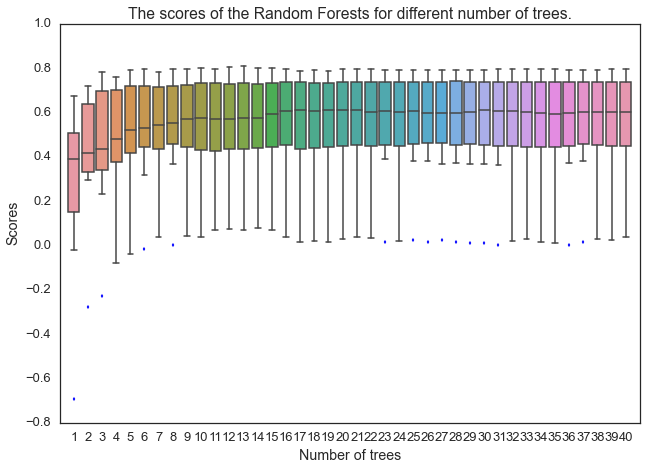

In [9]:
sns.set_context("talk")
sns.set_style("white")

sns.boxplot(np.matrix(scores))
plt.xlabel("Number of trees")
plt.ylabel("Scores")
plt.title("The scores of the Random Forests for different number of trees.")
plt.xlim(0,41)
plt.show()

Choose number of trees as 20.

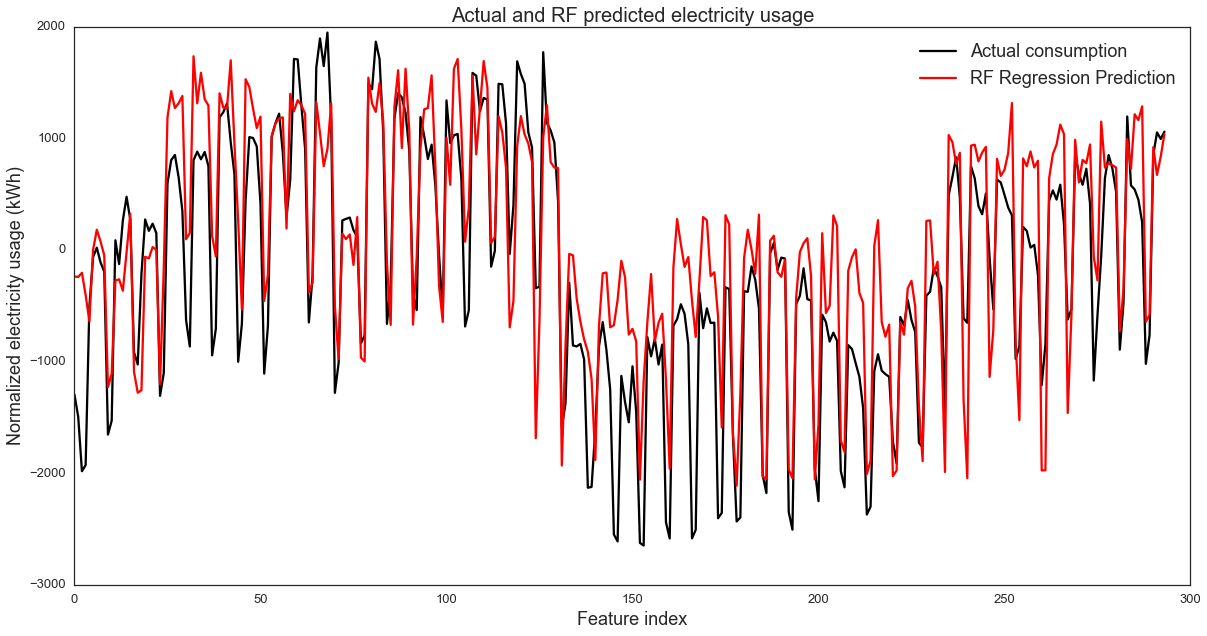

In [10]:
# Use the optimal number of trees for prediction:
RF_e = RandomForestRegressor(n_estimators=20, max_depth=None, min_samples_split=1, random_state=0)
RF_e.fit(XX_elect_train,YY_elect_train)
YY_elect_pred=RF_e.predict(XX_elect_test)

fig,ax = plt.subplots(1, 1,figsize=(20,10))
line1, =plt.plot(XX_elect_test.index, YY_elect_test, label='Actual consumption', color='k')
line2, =plt.plot(XX_elect_test.index, YY_elect_pred, label='RF Regression Prediction', color='r')
plt.xlabel('Feature index',fontsize=18)
plt.ylabel('Normalized electricity usage (kWh)',fontsize=18)
plt.title('Actual and RF predicted electricity usage',fontsize=20)
plt.legend([line1, line2], ['Actual consumption', 'RF Regression Prediction'],fontsize=18)
plt.show()



In [11]:
print RF_e.score(XX_elect_test,YY_elect_test)

0.679872383518


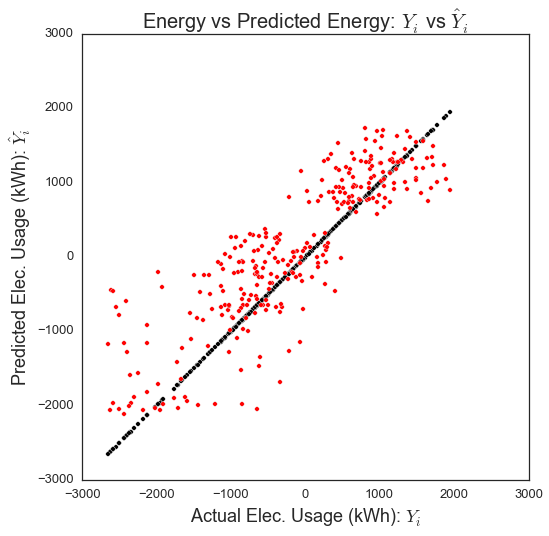

In [12]:
#Plot actual vs. prediced usage.
fig = plt.figure(figsize=(8,8))
plt.scatter(YY_elect_test, YY_elect_test, c='k')
plt.scatter(YY_elect_test, YY_elect_pred, c='r')
plt.xlabel('Actual Elec. Usage (kWh): $Y_i$',fontsize=18)
plt.ylabel("Predicted Elec. Usage (kWh): $\hat{Y}_i$",fontsize=18)
plt.title("Energy vs Predicted Energy: $Y_i$ vs $\hat{Y}_i$",fontsize=20)
plt.show()

Analysis of chilled water data.

In [13]:
chilledw_train = pd.DataFrame(data=normalized_chilledWater, index=np.arange('2012-01', '2014-01', dtype='datetime64[D]')).dropna()
chilledw_test = pd.DataFrame(data=normalized_chilledWater, index=np.arange('2014-01', '2014-11', dtype='datetime64[D]')).dropna()

XX_chilledw_train = chilledw_train.drop('chilledWater-TonDays', axis = 1).reset_index().drop('index', axis = 1)
XX_chilledw_test = chilledw_test.drop('chilledWater-TonDays', axis = 1).reset_index().drop('index', axis = 1)

YY_chilledw_train = chilledw_train['chilledWater-TonDays']
YY_chilledw_test = chilledw_test['chilledWater-TonDays']

print XX_chilledw_train.shape, XX_chilledw_test.shape

(705, 13) (294, 13)


In [14]:
# Find the optimal number of trees.
scores = pd.DataFrame()
for n in range(1,41):
    rf = RandomForestRegressor(n_estimators=n, max_depth=None, min_samples_split=1, random_state=0)
    score = cross_val_score(rf, XX_chilledw_train, YY_chilledw_train,cv=10)
    scores[n] = score


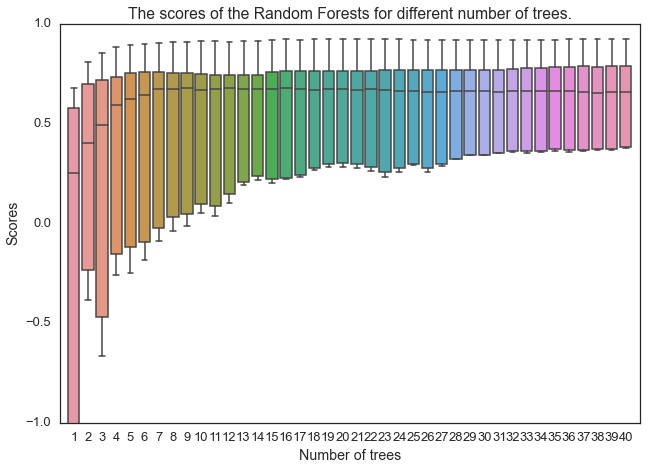

In [15]:
sns.set_context("talk")
sns.set_style("white")

sns.boxplot(np.matrix(scores))
plt.xlabel("Number of trees")
plt.ylabel("Scores")
plt.title("The scores of the Random Forests for different number of trees.")
plt.xlim(0,41)
plt.ylim(-1,1)
plt.show()

Choose number of trees as 20.

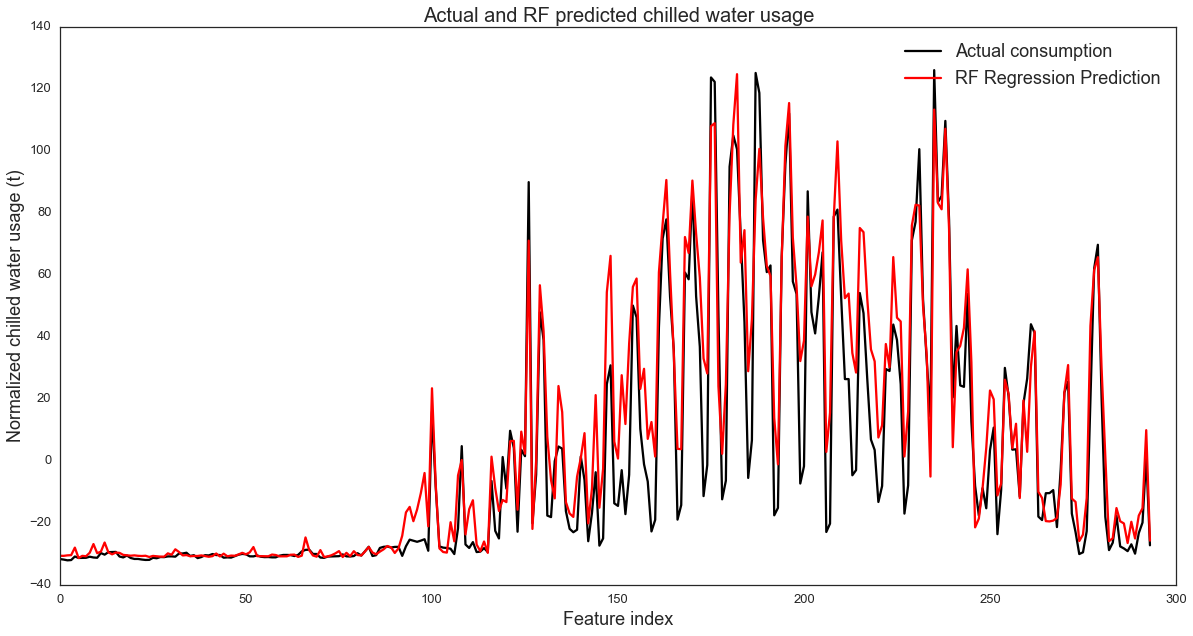

In [16]:
# Use the optimal number of trees for prediction:
RF_w = RandomForestRegressor(n_estimators=20, max_depth=None, min_samples_split=1, random_state=0)
RF_w.fit(XX_chilledw_train,YY_chilledw_train)
YY_chilledw_pred=RF_w.predict(XX_chilledw_test)

fig,ax = plt.subplots(1, 1,figsize=(20,10))
line1, =plt.plot(XX_chilledw_test.index, YY_chilledw_test, label='Actual consumption', color='k')
line2, =plt.plot(XX_chilledw_test.index, YY_chilledw_pred, label='RF Regression Prediction', color='r')
plt.xlabel('Feature index',fontsize=18)
plt.ylabel('Normalized chilled water usage (t)',fontsize=18)
plt.title('Actual and RF predicted chilled water usage',fontsize=20)
plt.legend([line1, line2], ['Actual consumption', 'RF Regression Prediction'],fontsize=18)
plt.show()

In [17]:
print RF_w.score(XX_chilledw_test,YY_chilledw_test)

0.883316960112


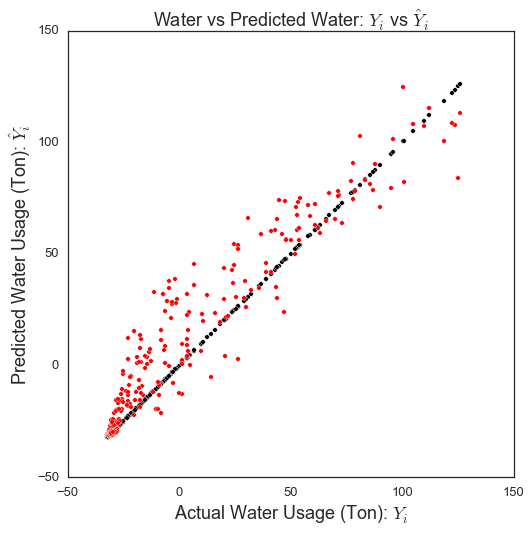

In [18]:
#Plot actual vs. prediced usage.
fig = plt.figure(figsize=(8,8))
plt.scatter(YY_chilledw_test, YY_chilledw_test, c='k')
plt.scatter(YY_chilledw_test, YY_chilledw_pred, c='r')
plt.xlabel('Actual Water Usage (Ton): $Y_i$',fontsize=18)
plt.ylabel("Predicted Water Usage (Ton): $\hat{Y}_i$",fontsize=18)
plt.title("Water vs Predicted Water: $Y_i$ vs $\hat{Y}_i$",fontsize=18)
plt.show()

Analysis of steam data.

In [19]:
steam_train = pd.DataFrame(data=normalized_steam, index=np.arange('2012-01', '2014-01', dtype='datetime64[D]')).dropna()
steam_test = pd.DataFrame(data=normalized_steam, index=np.arange('2014-01', '2014-11', dtype='datetime64[D]')).dropna()

XX_steam_train = steam_train.drop('steam-LBS', axis = 1).reset_index().drop('index', axis = 1)
XX_steam_test = steam_test.drop('steam-LBS', axis = 1).reset_index().drop('index', axis = 1)

YY_steam_train = steam_train['steam-LBS']
YY_steam_test = steam_test['steam-LBS']

print XX_steam_train.shape, XX_steam_test.shape

(705, 13) (294, 13)


In [20]:
# Find the optimal number of trees.
scores = pd.DataFrame()
for n in range(1,41):
    Rf = RandomForestRegressor(n_estimators=n, max_depth=None, min_samples_split=1, random_state=0)
    score = cross_val_score(Rf, XX_steam_train, YY_steam_train,cv=10)
    scores[n] = score

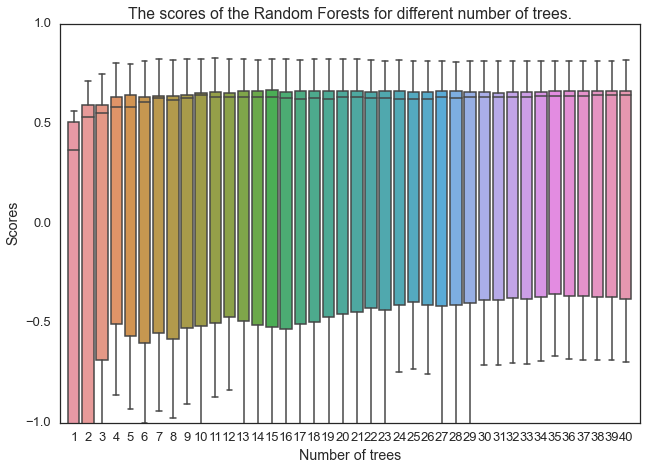

In [21]:
sns.set_context("talk")
sns.set_style("white")

sns.boxplot(np.matrix(scores))
plt.xlabel("Number of trees")
plt.ylabel("Scores")
plt.title("The scores of the Random Forests for different number of trees.")
plt.xlim(0,41)
plt.ylim(-1,1)
plt.show()

Choose number of trees as 21.

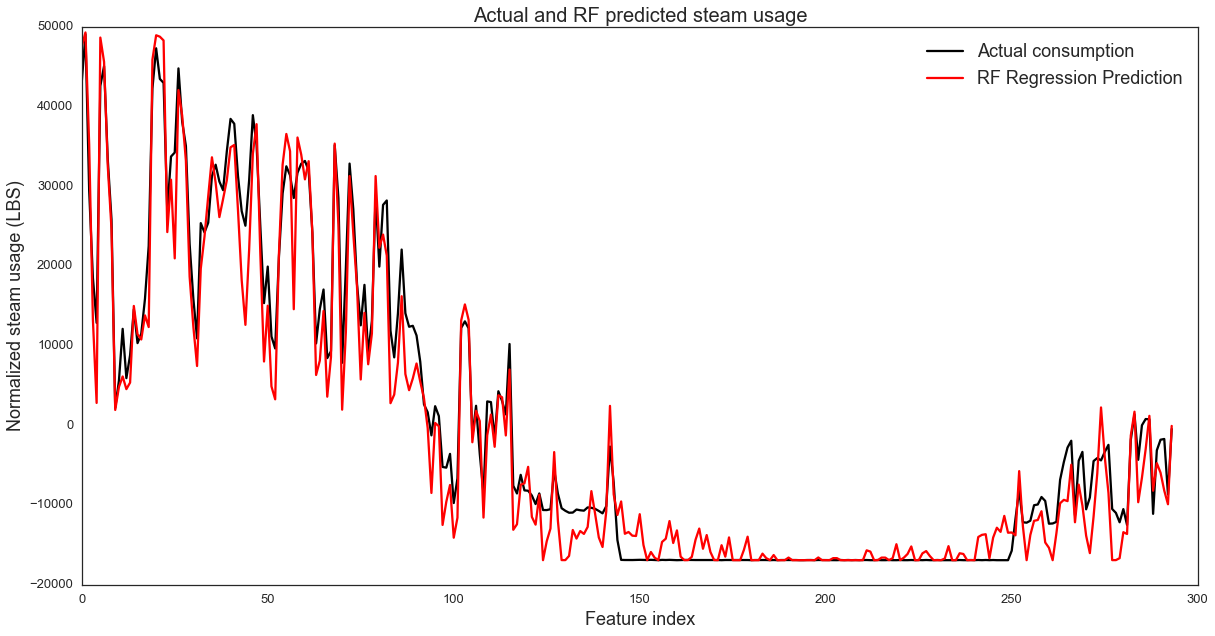

In [22]:
# Use the optimal number of trees for prediction:
RF_s = RandomForestRegressor(n_estimators=21, max_depth=None, min_samples_split=1, random_state=0)
RF_s.fit(XX_steam_train,YY_steam_train)
YY_steam_pred=RF_s.predict(XX_steam_test)

fig,ax = plt.subplots(1, 1,figsize=(20,10))
line1, =plt.plot(XX_steam_test.index, YY_steam_test, label='Actual consumption', color='k')
line2, =plt.plot(XX_steam_test.index, YY_steam_pred, label='RF Regression Prediction', color='r')
plt.xlabel('Feature index',fontsize=18)
plt.ylabel('Normalized steam usage (LBS)',fontsize=18)
plt.title('Actual and RF predicted steam usage',fontsize=20)
plt.legend([line1, line2], ['Actual consumption', 'RF Regression Prediction'],fontsize=18)
plt.show()

In [23]:
print RF_s.score(XX_steam_test,YY_steam_test)

0.960889669644


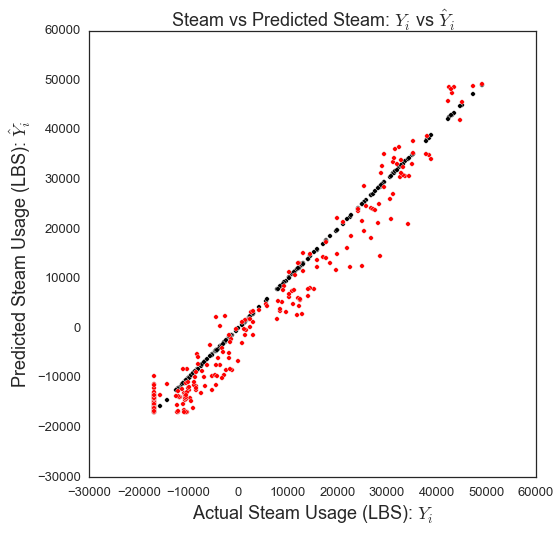

In [24]:
#Plot actual vs. prediced usage.
fig = plt.figure(figsize=(8,8))
plt.scatter(YY_steam_test, YY_steam_test, c='k')
plt.scatter(YY_steam_test, YY_steam_pred, c='r')
plt.xlabel('Actual Steam Usage (LBS): $Y_i$',fontsize=18)
plt.ylabel("Predicted Steam Usage (LBS): $\hat{Y}_i$",fontsize=18)
plt.title("Steam vs Predicted Steam: $Y_i$ vs $\hat{Y}_i$",fontsize=18)
plt.show()

## 5 K-Nearest Neighbours

In this notebook, we'll train a KNN Regression model for predicting building energy consumption based on historical enregy data and several weather variables. We'll use daily energy data and weather data to predict energy consumption.

In [25]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

pd.options.display.mpl_style = 'default'

In [26]:
import seaborn as sns 

import sklearn
import sklearn.datasets
import sklearn.cross_validation
import sklearn.decomposition
import sklearn.grid_search
import sklearn.neighbors
import sklearn.metrics

Building a KNN Regression model to predict the electricity consumption from the average adjusted weather attributes. To do this, we'll fit the model to daily electricity data and weather data from 2012-01-01 and compute the average squared residuals from predictions.

In [27]:
# read in original data:
electricity = pd.read_excel('Data/dailyElectricityWithFeatures.xlsx')
electricity = electricity.drop('startDay', 1).drop('endDay', 1)
#electricity = electricity.drop('humidityRatio-kg/kg',1).drop('coolingDegrees',1).drop('heatingDegrees',1).drop('dehumidification',1).drop('occupancy',1)
electricity = electricity.dropna()

chilledWater = pd.read_excel('Data/dailyChilledWaterWithFeatures.xlsx')
chilledWater = chilledWater.drop('startDay', 1).drop('endDay', 1)
chilledWater = chilledWater.dropna()

steam = pd.read_excel('Data/dailySteamWithFeatures.xlsx')
steam = steam.drop('startDay', 1).drop('endDay', 1)
steam = steam.dropna()

In [28]:
# normalize data:
normalized_electricity = electricity - electricity.mean()
normalized_chilledWater = chilledWater - chilledWater.mean()
normalized_steam = steam - steam.mean()

Adding a new column to specify if working days or weekends and holidays. We'll set working days to 0, and weekends and holidays to 1. US public holidays are listed here, http://www.officeholidays.com/countries/usa/ We may also remove vacations times when there is no school, but we'll do it since we don't have this information.

In [29]:
# Initialization all days to 0
normalized_electricity['day_type'] = np.zeros(len(normalized_electricity))
normalized_chilledWater['day_type'] = np.zeros(len(normalized_chilledWater))
normalized_steam['day_type'] = np.zeros(len(normalized_steam))

# Set weekends to 1
normalized_electricity['day_type'][(normalized_electricity.index.dayofweek==5)|(normalized_electricity.index.dayofweek==6)] = 1
normalized_chilledWater['day_type'][(normalized_chilledWater.index.dayofweek==5)|(normalized_chilledWater.index.dayofweek==6)] = 1
normalized_steam['day_type'][(normalized_steam.index.dayofweek==5)|(normalized_steam.index.dayofweek==6)] = 1

# Set holidays to 1
holidays = ['2014-01-01','2014-01-20','2014-05-26','2014-07-04','2014-09-01','2014-11-11','2014-11-27','2014-12-25','2013-01-01',
            '2013-01-21','2013-05-27','2013-07-04','2013-09-02','2013-11-11','2013-11-27','2013-12-25','2012-01-01','2012-01-16',
            '2012-05-28','2012-07-04','2012-09-03','2012-11-12','2012-11-22','2012-12-25']

for i in range(len(holidays)):
    normalized_electricity['day_type'][normalized_electricity.index.date==np.datetime64(holidays[i])] = 1
    normalized_chilledWater['day_type'][normalized_chilledWater.index.date==np.datetime64(holidays[i])] = 1
    normalized_steam['day_type'][normalized_steam.index.date==np.datetime64(holidays[i])] = 1

Analysis of electricity data.

In [30]:
# Split train and test data:
elect_train = pd.DataFrame(data=normalized_electricity, index=np.arange('2012-01', '2014-01', dtype='datetime64[D]')).dropna()
elect_test = pd.DataFrame(data=normalized_electricity, index=np.arange('2014-01', '2014-11', dtype='datetime64[D]')).dropna()

XX_elect_train = elect_train.drop('electricity-kWh', axis = 1).reset_index().drop('index', axis = 1)
XX_elect_test = elect_test.drop('electricity-kWh', axis = 1).reset_index().drop('index', axis = 1)

YY_elect_train = elect_train['electricity-kWh']
YY_elect_test = elect_test['electricity-kWh']

print XX_elect_train.shape, XX_elect_test.shape

(634, 13) (294, 13)


In [31]:
def accuracy_for_k(k,x,y):
    split_data=sklearn.cross_validation.train_test_split(x,y,test_size=0.33,random_state=99)
    X_train,X_test,Y_train,Y_test=split_data
    knn=sklearn.neighbors.KNeighborsRegressor(n_neighbors=k,weights='uniform')
    knn.fit(X_train,Y_train)
    #Y_hat=knn.predict(X_test)
    value=knn.score(X_test,Y_test)
    return value


0.0305837055412
The optimal value of k is: 30


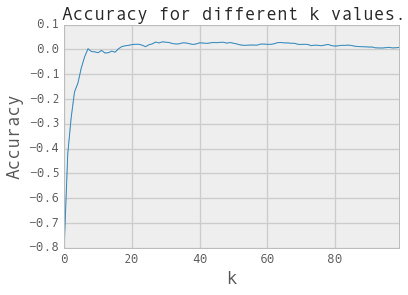

In [32]:
# Find the optimal number of k in knn:
k_values=range(1,101)
scores=np.zeros(len(k_values))
for k, c_k in zip(k_values,range(len(k_values))):
    value=accuracy_for_k(k=k,x=XX_elect_train,y=YY_elect_train)
    scores[c_k]=value
    
k_opt=np.argmax(scores)+1
print scores.max()
print 'The optimal value of k is:',k_opt

sns.tsplot(scores.T)
#plt.xticks(range(len(k_values)),k_values)
plt.xlabel('k',fontsize=18)
plt.ylabel('Accuracy',fontsize=18)
plt.title('Accuracy for different k values.',fontsize=18)
plt.show()

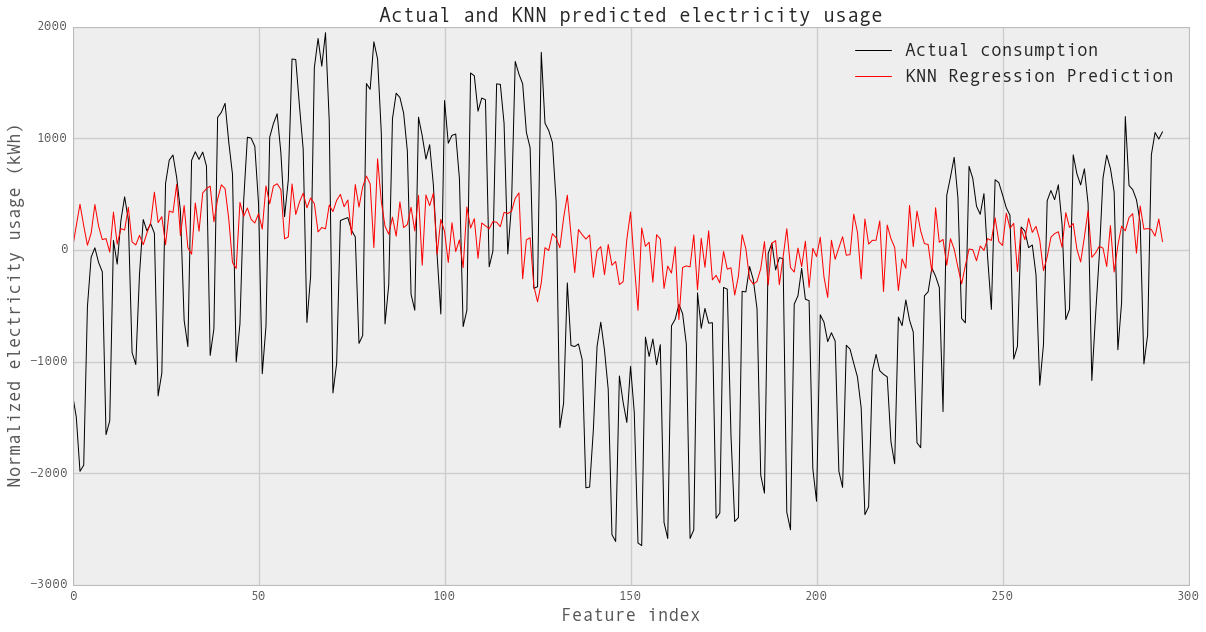

In [33]:
# Use the optimal k for prediction:
knn_reg=sklearn.neighbors.KNeighborsRegressor(n_neighbors=31,weights='uniform')
knn_reg.fit(XX_elect_train,YY_elect_train)
YY_elect_pred=knn_reg.predict(XX_elect_test)

fig,ax = plt.subplots(1, 1,figsize=(20,10))
line1, =plt.plot(XX_elect_test.index, YY_elect_test, label='Actual consumption', color='k')
line2, =plt.plot(XX_elect_test.index, YY_elect_pred, label='KNN Regression Prediction', color='r')
plt.xlabel('Feature index',fontsize=18)
plt.ylabel('Normalized electricity usage (kWh)',fontsize=18)
plt.title('Actual and KNN predicted electricity usage',fontsize=20)
plt.legend([line1, line2], ['Actual consumption', 'KNN Regression Prediction'],fontsize=18)
plt.show()

In [34]:
print knn_reg.score(XX_elect_test,YY_elect_test)

0.0450538207392


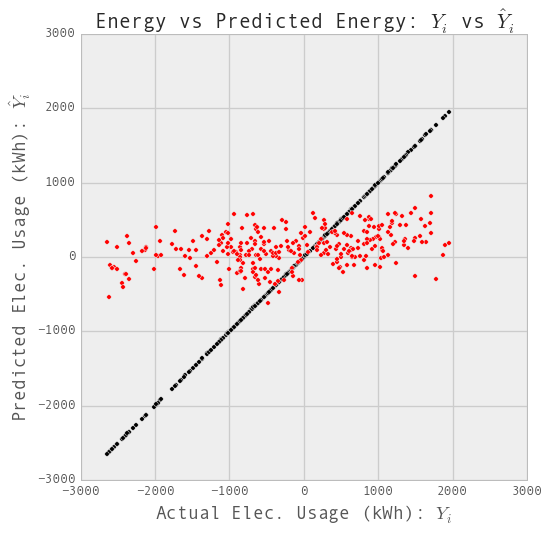

In [35]:
#Plot actual vs. prediced usage.
fig = plt.figure(figsize=(8,8))
plt.scatter(YY_elect_test, YY_elect_test, c='k')
plt.scatter(YY_elect_test, YY_elect_pred, c='r')
plt.xlabel('Actual Elec. Usage (kWh): $Y_i$',fontsize=18)
plt.ylabel("Predicted Elec. Usage (kWh): $\hat{Y}_i$",fontsize=18)

plt.title("Energy vs Predicted Energy: $Y_i$ vs $\hat{Y}_i$",fontsize=20)
plt.show()

Analysis of chilled water data.

In [36]:
chilledw_train = pd.DataFrame(data=normalized_chilledWater, index=np.arange('2012-01', '2014-01', dtype='datetime64[D]')).dropna()
chilledw_test = pd.DataFrame(data=normalized_chilledWater, index=np.arange('2014-01', '2014-11', dtype='datetime64[D]')).dropna()

XX_chilledw_train = chilledw_train.drop('chilledWater-TonDays', axis = 1).reset_index().drop('index', axis = 1)
XX_chilledw_test = chilledw_test.drop('chilledWater-TonDays', axis = 1).reset_index().drop('index', axis = 1)

YY_chilledw_train = chilledw_train['chilledWater-TonDays']
YY_chilledw_test = chilledw_test['chilledWater-TonDays']

print XX_chilledw_train.shape, XX_chilledw_test.shape

(705, 13) (294, 13)


0.62985747618
The optimal value of k is: 6


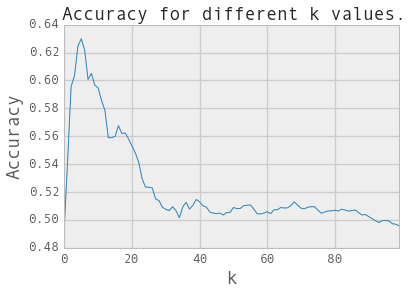

In [37]:
# Find the optimal number of k in knn:
k_values=range(1,101)
scores=np.zeros(len(k_values))
for k, c_k in zip(k_values,range(len(k_values))):
    value=accuracy_for_k(k=k,x=XX_chilledw_train,y=YY_chilledw_train)
    scores[c_k]=value
    
k_opt=np.argmax(scores)+1
print scores.max()
print 'The optimal value of k is:',k_opt

sns.tsplot(scores.T)
#plt.xticks(range(len(k_values)),k_values)
plt.xlabel('k',fontsize=18)
plt.ylabel('Accuracy',fontsize=18)
plt.title('Accuracy for different k values.',fontsize=18)
plt.show()

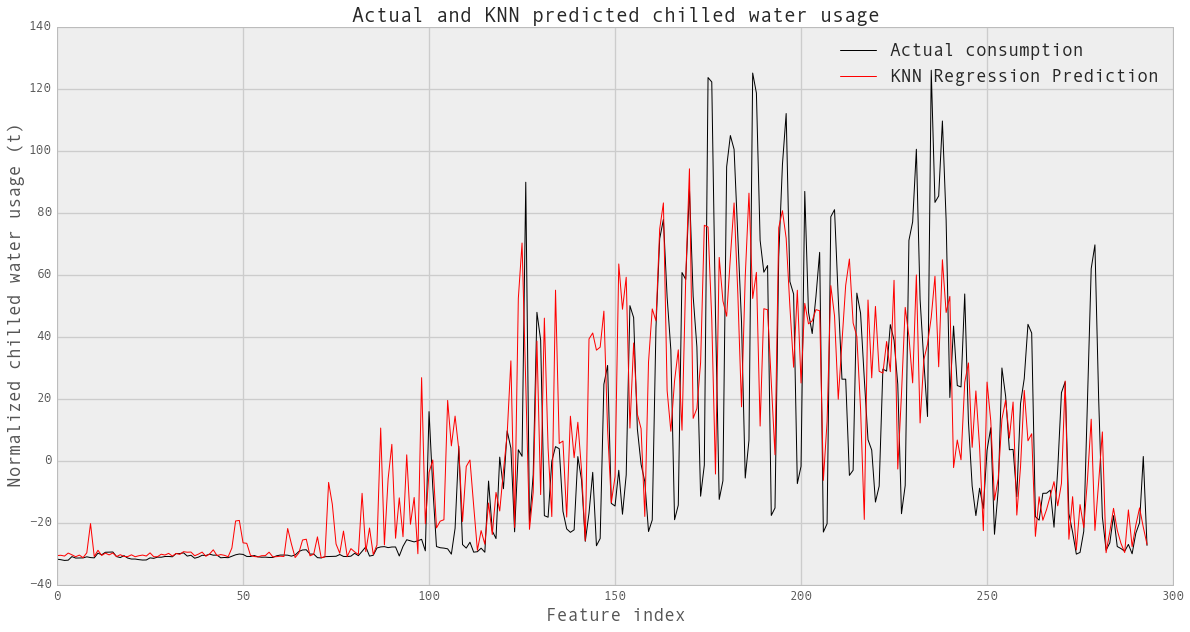

In [38]:
# Use the optimal k for prediction:
knn_reg_w=sklearn.neighbors.KNeighborsRegressor(n_neighbors=6,weights='uniform')
knn_reg_w.fit(XX_chilledw_train,YY_chilledw_train)
YY_chilledw_pred=knn_reg_w.predict(XX_chilledw_test)

fig,ax = plt.subplots(1, 1,figsize=(20,10))
line1, =plt.plot(XX_chilledw_test.index, YY_chilledw_test, label='Actual consumption', color='k')
line2, =plt.plot(XX_chilledw_test.index, YY_chilledw_pred, label='KNN Regression Prediction', color='r')
plt.xlabel('Feature index',fontsize=18)
plt.ylabel('Normalized chilled water usage (t)',fontsize=18)
plt.title('Actual and KNN predicted chilled water usage',fontsize=20)
plt.legend([line1, line2], ['Actual consumption', 'KNN Regression Prediction'],fontsize=18)
plt.show()

In [39]:
print knn_reg_w.score(XX_chilledw_test,YY_chilledw_test)

0.50450369365


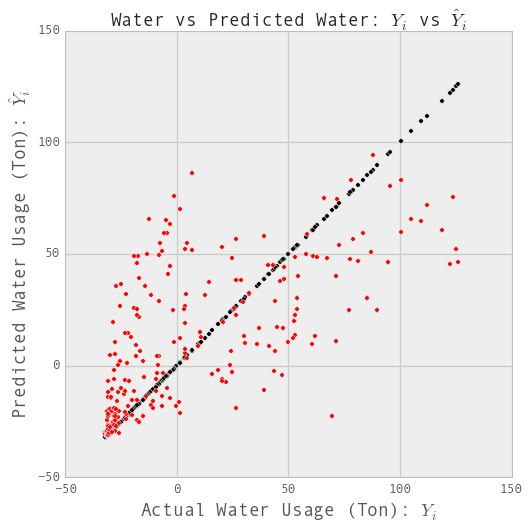

In [40]:
#Plot actual vs. prediced usage.
fig = plt.figure(figsize=(8,8))
plt.scatter(YY_chilledw_test, YY_chilledw_test, c='k')
plt.scatter(YY_chilledw_test, YY_chilledw_pred, c='r')
plt.xlabel('Actual Water Usage (Ton): $Y_i$',fontsize=18)
plt.ylabel("Predicted Water Usage (Ton): $\hat{Y}_i$",fontsize=18)
plt.title("Water vs Predicted Water: $Y_i$ vs $\hat{Y}_i$",fontsize=18)
plt.show()

Analysis of steam data.

In [41]:
steam_train = pd.DataFrame(data=normalized_steam, index=np.arange('2012-01', '2014-01', dtype='datetime64[D]')).dropna()
steam_test = pd.DataFrame(data=normalized_steam, index=np.arange('2014-01', '2014-11', dtype='datetime64[D]')).dropna()

XX_steam_train = steam_train.drop('steam-LBS', axis = 1).reset_index().drop('index', axis = 1)
XX_steam_test = steam_test.drop('steam-LBS', axis = 1).reset_index().drop('index', axis = 1)

YY_steam_train = steam_train['steam-LBS']
YY_steam_test = steam_test['steam-LBS']

print XX_steam_train.shape, XX_steam_test.shape

(705, 13) (294, 13)


0.760976988296
The optimal value of k is: 3


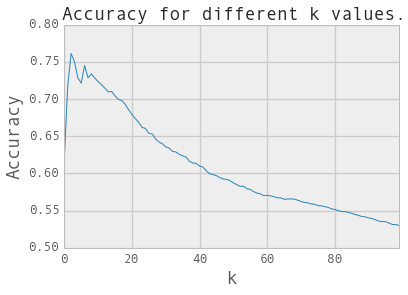

In [42]:
# Find the optimal number of k in knn:
k_values=range(1,101)
scores=np.zeros(len(k_values))
for k, c_k in zip(k_values,range(len(k_values))):
    value=accuracy_for_k(k=k,x=XX_steam_train,y=YY_steam_train)
    scores[c_k]=value
    
k_opt=np.argmax(scores)+1
print scores.max()
print 'The optimal value of k is:',k_opt

sns.tsplot(scores.T)
#plt.xticks(range(len(k_values)),k_values)
plt.xlabel('k',fontsize=18)
plt.ylabel('Accuracy',fontsize=18)
plt.title('Accuracy for different k values.',fontsize=18)
plt.show()

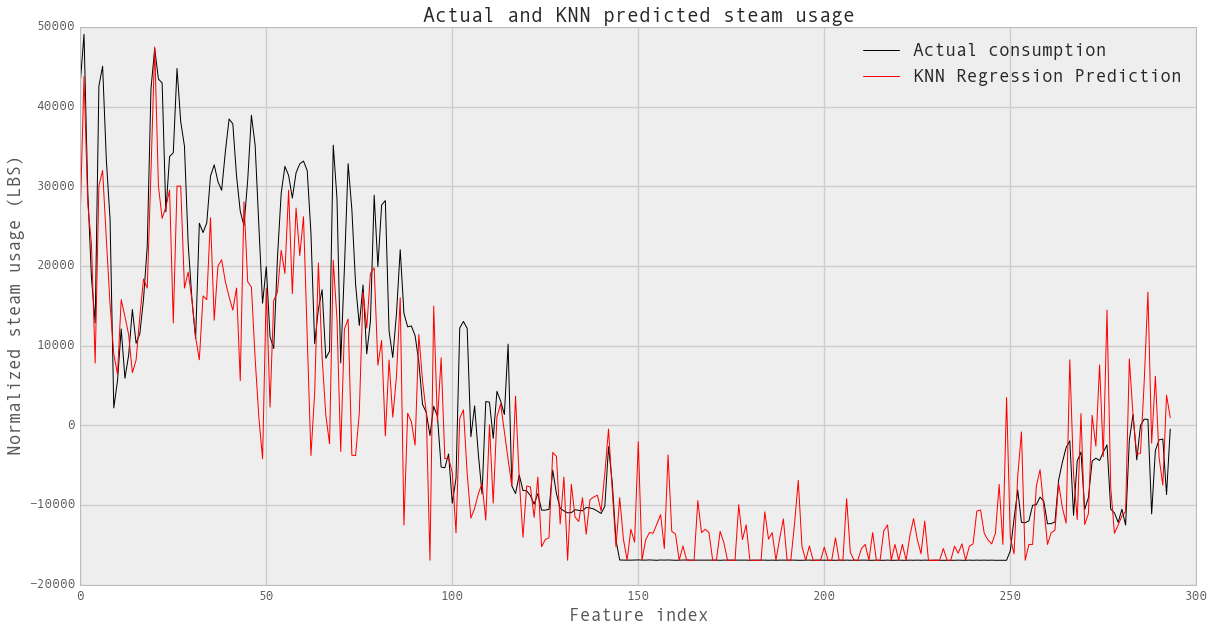

In [43]:
# Use the optimal k for prediction:
knn_reg_s=sklearn.neighbors.KNeighborsRegressor(n_neighbors=3,weights='uniform')
knn_reg_s.fit(XX_steam_train,YY_steam_train)
YY_steam_pred=knn_reg_s.predict(XX_steam_test)

fig,ax = plt.subplots(1, 1,figsize=(20,10))
line1, =plt.plot(XX_steam_test.index, YY_steam_test, label='Actual consumption', color='k')
line2, =plt.plot(XX_steam_test.index, YY_steam_pred, label='KNN Regression Prediction', color='r')
plt.xlabel('Feature index',fontsize=18)
plt.ylabel('Normalized steam usage (LBS)',fontsize=18)
plt.title('Actual and KNN predicted steam usage',fontsize=20)
plt.legend([line1, line2], ['Actual consumption', 'KNN Regression Prediction'],fontsize=18)
plt.show()

In [44]:
print knn_reg_s.score(XX_steam_test,YY_steam_test)

0.787718743908


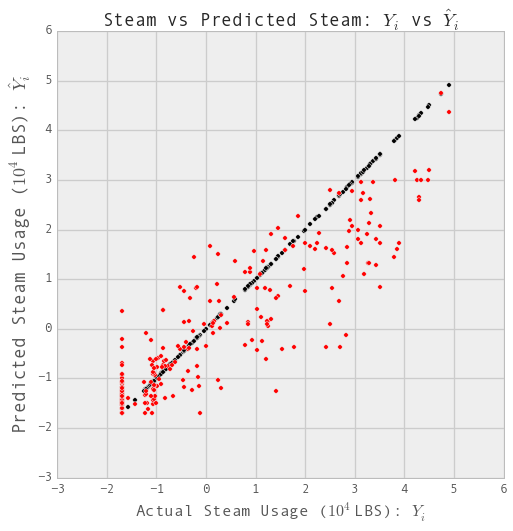

In [45]:
#Plot actual vs. prediced usage.
fig = plt.figure(figsize=(8,8))
plt.scatter(YY_steam_test/10000, YY_steam_test/10000, c='k')
plt.scatter(YY_steam_test/10000, YY_steam_pred/10000, c='r')
plt.xlabel('Actual Steam Usage ($10^4$LBS): $Y_i$',fontsize=16)
plt.ylabel("Predicted Steam Usage ($10^4$LBS): $\hat{Y}_i$",fontsize=18)
plt.title("Steam vs Predicted Steam: $Y_i$ vs $\hat{Y}_i$",fontsize=18)
plt.show()